1. Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])


def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)


def bias(y, z):
    return (y - z)

In [12]:
def gb_fit(X_train, y_train, X_test, y_test, n_trees, max_depth, coefs, eta):
    trees = []
    train_errors = []
    test_errors = []
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if len(trees) == 0:
            tree.fit(X_train, y_train)
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            target = gb_predict(X_train, trees, coefs, eta)
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        trees.append(tree)
    return trees, train_errors, test_errors

In [100]:
def plot_mse_surface(errors_matrix, n_trees_array, max_depth_array):
    fig, ax = plt.subplots(1, figsize=(9, 6))
    divider = make_axes_locatable(ax)
    ax_cb = divider.append_axes("right", size = "10%")
    p = ax.imshow(errors_matrix, cmap='jet', origin='lower')
    ax.set_xlabel('Максимальное число деревьев')
    ax.set_ylabel('Максимальная глубина дерева')
    ax.set_xticks(n_trees_array - 1)
    ax.set_yticks(max_depth_array - 1)
    ax.set_xticklabels(n_trees_array)
    ax.set_yticklabels(max_depth_array)
    cbar = p.axes.figure.colorbar(p, cax=ax_cb)
    cbar.set_label('MSE')

In [13]:
X, y = load_diabetes(return_X_y=True)

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [101]:
n_t, n_m = 20, 10
n_trees_array = np.linspace(1, n_t, n_t, dtype=np.int64)
max_depth_array = np.linspace(1, n_m, n_m, dtype=np.int64)
errors_matrix = [gb_fit(X_train, y_train, X_test, y_test, n_t, j, [1]*n_t, 1)[1:] for j in max_depth_array]
train_errors_matrix = [l[0] for l in errors_matrix]
test_errors_matrix = [l[1] for l in errors_matrix]

Ошибки на трейне:

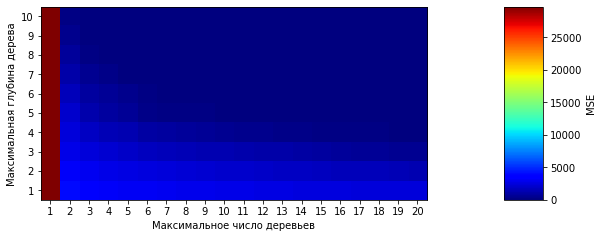

In [102]:
plot_mse_surface(train_errors_matrix, n_trees_array, max_depth_array)
plt.show()

При увеличении глубины и числа деревьев появляются признаки переобучения.

Ошибки на тесте:

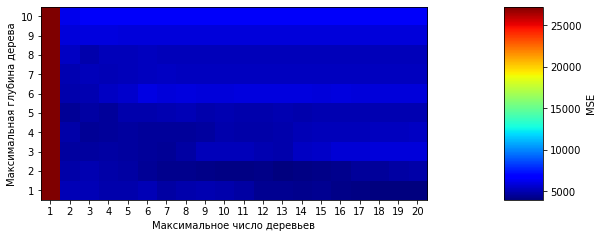

In [103]:
plot_mse_surface(test_errors_matrix, n_trees_array, max_depth_array)
plt.show()

Оптимально выбрать небольшую глубину деревьев с умеренным их количеством. Например, максимальная глубина 2, число деревьев 13.

2. Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [85]:
def gb_stoch_fit(X_train, y_train, X_test, y_test, n_trees, max_depth, coefs, eta):
    trees = []
    train_errors = []
    test_errors = []
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        X_sub_train, _, y_sub_train, _ = model_selection.train_test_split(X, y, test_size=0.5, random_state=42)
        if len(trees) == 0:
            tree.fit(X_sub_train, y_sub_train)
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            target = gb_predict(X_sub_train, trees, coefs, eta)
            tree.fit(X_sub_train, bias(y_sub_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        trees.append(tree)
    return trees, train_errors, test_errors

In [92]:
n_trees_array = np.linspace(1, 20, 20, dtype=np.int64)
_, _, test_gb_mse = gb_fit(X_train, y_train, X_test, y_test, n_trees_array[-1], 3, [1]*n_trees_array[-1], 1)
_, _, test_gbs_mse = gb_stoch_fit(X_train, y_train, X_test, y_test, n_trees_array[-1], 3, [1]*n_trees_array[-1], 1)

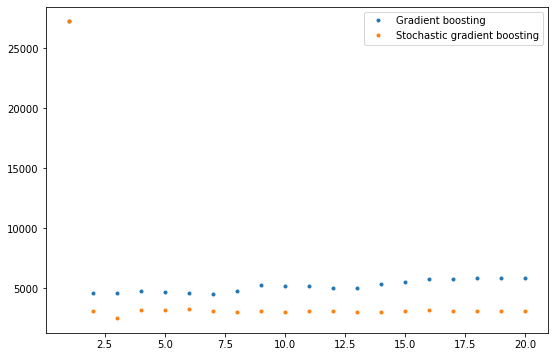

In [93]:
fig, ax = plt.subplots(1, figsize=(9, 6))
ax.plot(n_trees_array, test_gb_mse, '.', label='Gradient boosting')
ax.plot(n_trees_array, test_gbs_mse, '.', label='Stochastic gradient boosting')
ax.legend()

Стохастический градиентный бустинг позволяет получить меньшую MSE на тесте.